# Going beyond $S_8$: fast inference of the matter power spectrum from weak-lensing surveys

This notebook accompanies the paper **“Going beyond $S_8$: fast inference of the matter power spectrum from weak-lensing surveys”** and provides a step-by-step guide to reproduce its key results. Our goal is to reconstruct the scale-dependent deviations $\alpha(k)$ to the nonlinear matter power spectrum $P(k,z)$ using weak lensing observations, and to assess consistency with the fiducial Planck ΛCDM cosmology.

We implement a fast, linearized forward model of the angular power spectra $C_\ell$, invert it using Bayesian inference, and explore posterior constraints on $\alpha(k)$ using Hamiltonian Monte Carlo. This framework allows for rapid, flexible analysis of tomographic lensing data without assuming a specific physical model for deviations.

## 🔍 What this notebook does
Loads public cosmic shear data from DES Y3, KiDS-1000, HSC Y3, and CMB lensing from ACT DR6

- Loads public cosmic shear data from **DES Y3**, **KiDS-1000**, **HSC Y3**, and CMB lensing from **ACT DR6**
- Builds the linear forward model relating $\alpha(k)$ to $C_\ell$ under the Limber approximation
- Applies priors and accounts for systematics like redshift uncertainties and shear calibration biases
- Runs Bayesian inference to obtain posterior distributions on $\alpha(k)$ and visualizes deviations from ΛCDM
- Reproduces main figures and results from the paper

## 🛠 Requirements
This notebook uses:
- `numpy`, `scipy`, `matplotlib`
- `astropy`, `twopoint`, `sacc` to load datasets
- `pyccl` for cosmological computations
- `pymc` (v4+), `nautilus` and `getdist` for inference and visualization

Our custom utilities (e.g., for window function construction and systematics covariance) are in in `cls2pk/`.

## 📂 Folder structure
- `data/`: Public lensing spectra and redshift distributions
- `res/`: Preprocessed lensing window matrices, covariance, etc
- `chains/`: Saved $\alpha(k)$ posterior samples

## 📈 Running the notebook
You can run the notebook cell-by-cell to follow the methodology. All results in the paper use this code, simply adapted to try various configurations. Running $\alpha(k)$ inference should only take a minute or so.

In [1]:
import os

os.environ["OMP_NUM_THREADS"] = "1"  # Needed for nautilus

import numpy as np
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.io import fits
import twopoint
import sacc

import pyccl
from pymc import Model, Uniform, MvNormal, math, sample, Normal
from nautilus import Prior, Sampler
from getdist import MCSamples, plots

import cls2pk

%matplotlib inline

## Fiducial model: Planck ΛCDM 2018
We start by declaring our fiducial model and $k$ binning. Here we use 24 logarithmic bins between $10^{-3}$ and $10^2{\rm Mpc}^{-1}$, as in the paper, since it provides a trade-off between accuracy and speed, but this can be changed. The smoothing might need to be adjusted too.

In [2]:
# Planck 2018 LCDM cosmology with TT,TE,EE+lowE
planck_params = dict(omega_b=0.02236, omega_c=0.1202, ln10e10As=3.045, n_s=0.9649, H0=67.27, Amod=1.)
params = dict(
    A_s=np.exp(planck_params['ln10e10As']) * 1e-10,
    Omega_c=planck_params['omega_c'] / (planck_params['H0'] / 100.)**2,
    Omega_b=planck_params['omega_b'] / (planck_params['H0'] / 100.)**2,
    h=planck_params['H0'] / 100.,
    n_s=planck_params['n_s'],
    m_nu=[0.06, 0., 0.],
    Neff=3.046)

# Cosmological model
cosmo = pyccl.Cosmology(**params)

In [3]:
# logk bins
nk = 24
kk_edges = np.logspace(-3, 2, nk + 1)
kk = np.exp(0.5 * (np.log(kk_edges[1:]) + np.log(kk_edges[:-1])))

## Data
We preprocess lensing data from DES, KiDS, HSC and ACT as follows:
1. Load $C_\ell$ measurements, covariance matrix, redshift distributions, redshift and shear uncertainty priors.
2. Compute window matrices including $C_\ell$ bandpower windows and systematics marginalization covariance.
3. Save these to be ready for $\alpha(k)$ inference.

Let us first define a utility function for all datasets.

In [4]:
def prepare_data(cosmo, label, ell, kk, tracers, bin_pairs, cl_dict, cov, mu_z=None, sigma_z=None, mu_shear=None, sigma_shear=None, ell_edges=None, bpws=None):
    """
    Computes window matrices, saves ingredients for sampling and makes some plots
    """
    # Cl's from Limber equation
    cl_pred = cls2pk.predict_cls(cosmo, ell, tracers, bin_pairs, ms=mu_shear, return_dict=True)
    cl_pred_stack = np.concatenate([cl_pred[b] for b in bin_pairs])

    n = len(tracers)

    try:
        cl_stack = np.load(f'res/{label}_cl_stack.npy')
        cov = np.load(f'res/{label}_cl_cov.npy')
        cov_syst = np.load(f'res/{label}_cl_cov_syst.npy')
        window_matrix = np.load(f'res/{label}_window_matrix.npy')
        kk = np.load(f'res/{label}_kk.npy')

    except FileNotFoundError:
        # Data Cl's
        cl_stack = np.concatenate([cl_dict[b] for b in bin_pairs])

        # Window matrix
        cl_lnk_dict, window_matrix = cls2pk.get_cl_lnk_window_matrix(cosmo, ell, kk, tracers, bin_pairs, ms=mu_shear, bpws=bpws)

        # Systematics marginalization covariance
        if sigma_z is None or sigma_shear is None:
            cov_syst = np.zeros_like(cov)
        else:
            cov_syst = cls2pk.compute_cov_syst(cosmo, ell, nz_z, nz_n, bin_pairs, mu_z, sigma_z, mu_shear, sigma_shear)

        # Save all
        np.save(f'res/{label}_cl_stack.npy', cl_stack)
        np.save(f'res/{label}_cl_cov.npy', cov)
        np.save(f'res/{label}_cl_cov_syst.npy', cov_syst)
        np.save(f'res/{label}_window_matrix.npy', window_matrix)
        np.save(f'res/{label}_kk.npy', kk)

        # Make plots
        ## Plot 0: corner plot of Cl's
        fig, axes = plt.subplots(n, n, figsize=(n * 3, n * 2), sharex=True, sharey='row', squeeze=False)
        for i in range(n):
            for j in range(n):
                ax = axes[i, j]
                if (i, j) not in bin_pairs:
                    ax.axis('off')
                else:
                    ax.loglog(ell, cl_pred[i, j], c='r', lw=1)
                    ax.plot(ell, np.dot(cl_lnk_dict[i, j], np.ones(nk)) * np.log(kk[1] / kk[0]), c='#1f4eb3', lw=1)
                    ax.loglog(ell, cl_dict[i, j], '.', c='orange')
                    ax.set_xlabel(r'$\ell$')
                    ax.set_ylabel(r'$C_\ell$')
                    ax.set_title(f'{i} {j}')
        plt.suptitle('Data points')
        plt.tight_layout()
        plt.show()

    ## Plot 1: redshift distributions and kernels
    fig, axes = plt.subplots(2, 1, figsize=(4, 6), sharex=True)
    axes[0].set_ylabel(r'$n(z)$')
    axes[1].set_ylabel(r'$q(z)$')
    axes[1].set_xlabel(r'Redshift $z$')
    colors = mpl.cm.YlOrRd(np.linspace(0.2, 1, n))
    zz = np.linspace(0, 3, 200)
    chi = cosmo.comoving_radial_distance(1 / (1 + zz))
    for t, c in zip(tracers, colors):
        try:
            axes[0].plot(zz, t.get_dndz(zz), c=c)
        except AttributeError:
            pass
        axes[1].plot(zz, t.get_kernel(chi)[0], c=c)

    ## Plot 2: stacked Cl's (to check ordering)
    plt.figure(figsize=(n * 4, 3))
    m = np.dot(window_matrix, np.ones(nk))  # Model
    s = np.sqrt(np.diagonal(cov + cov_syst))  # Error bars
    plt.semilogy(cl_pred_stack, lw=1, c='r', label='Full theory')
    plt.semilogy(m, lw=1, c='#1f4eb3', label='Linearized theory')
    plt.errorbar(np.arange(len(cl_stack)), cl_stack, s, ls=' ', elinewidth=1, marker='.', c='orange', label='Data')
    plt.xlim(-1, len(m))
    plt.xlabel('Data point index')
    plt.ylabel(r'$C_\ell$')
    plt.legend()
    plt.title('Data points')
    plt.tight_layout()
    plt.show()

    # Plot 3: covariance matrices
    fig, axes = plt.subplots(1, 3, figsize=(10, 3))
    im = axes[0].matshow(cov, norm=mpl.colors.LogNorm(vmin=1e-24, vmax=1e-16))
    plt.colorbar(im, ax=axes[0])
    axes[0].set_title('Data')
    if np.any(np.abs(cov_syst) > 0.):
        im = axes[1].matshow(cov_syst, norm=mpl.colors.LogNorm(vmin=1e-24, vmax=1e-16))
        plt.colorbar(im, ax=axes[1])
    axes[1].set_title('Systematics')
    axes[2].plot(np.sqrt(np.diagonal(cov + cov_syst) / np.diagonal(cov)), c='#1f4eb3')
    axes[2].set_title('Ratio of covariance w/wo syst')
    plt.suptitle('Covariance matrices')
    plt.tight_layout()
    plt.show()

    # Plot 4 (optional): bandpower windows
    if bpws is not None:
        plt.figure(figsize=(4, 3))
        nell = len(ell)
        colors = mpl.cm.YlOrRd(np.linspace(0.2, 1, nell))
        for i in range(nell):
            plt.semilogx(bpws[i], c=colors[i])
        if ell_edges is not None:
            for l in ell_edges:
                plt.axvline(l, c='.8', zorder=-99)
        plt.xlabel(r'$\ell$')
        plt.title('Bandpower windows')
        plt.tight_layout()
        plt.show()

### DES Year 3

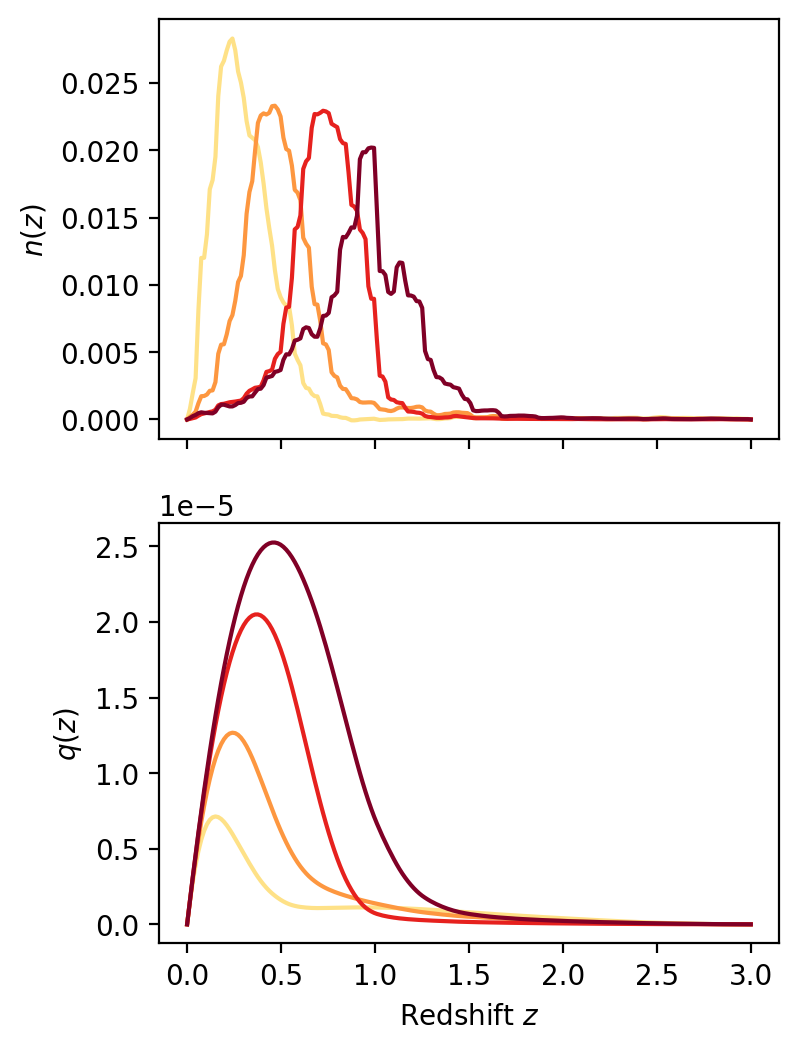

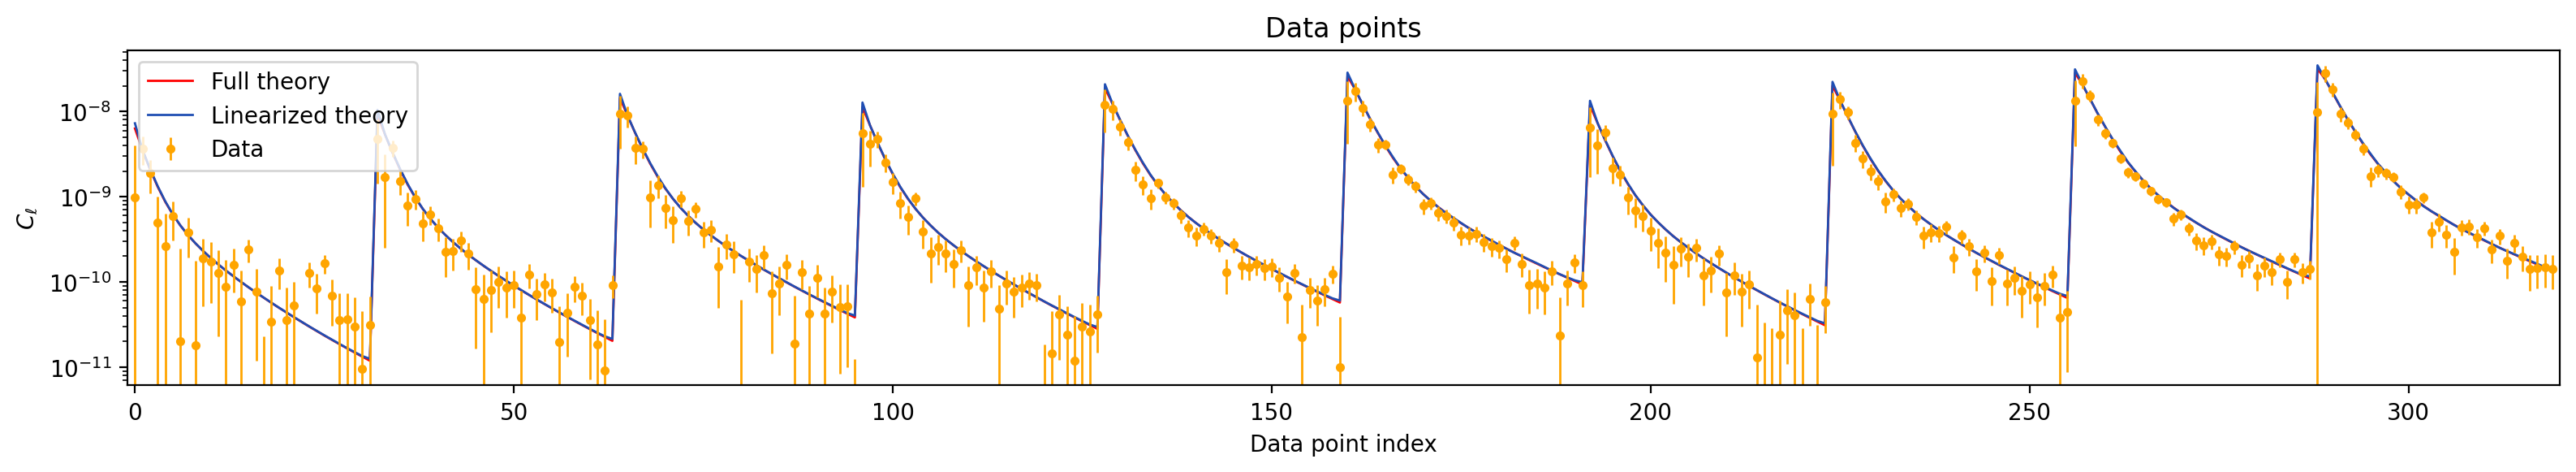

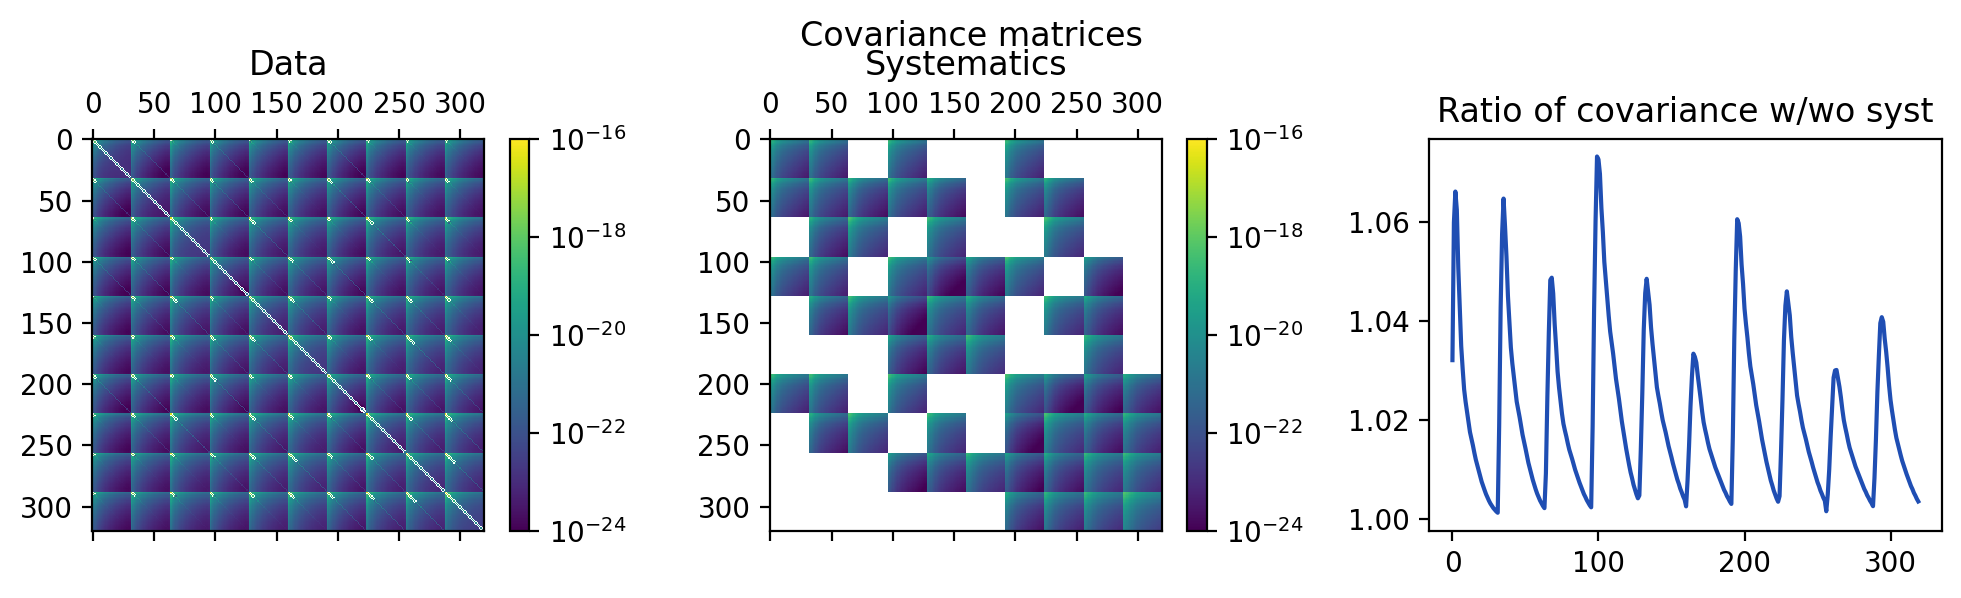

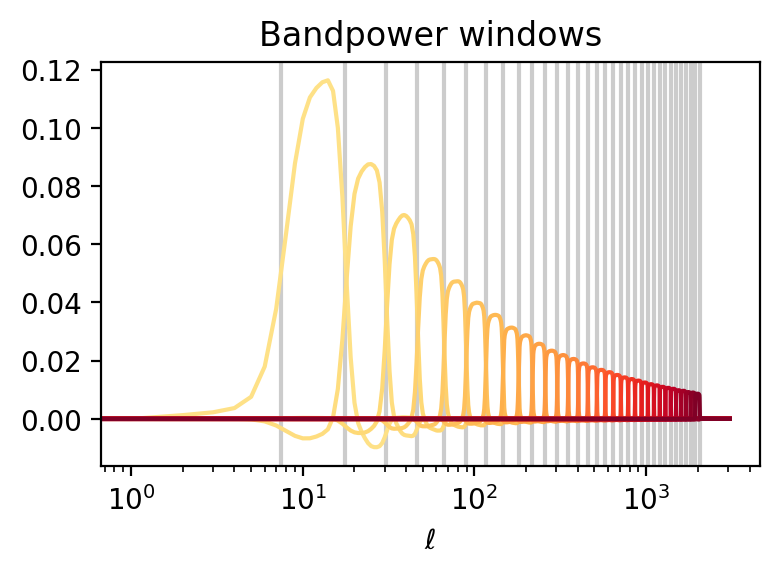

In [5]:
label = f'DES_nk{nk}'

datafile = 'data/twopoint_cls_Y3_mastercat_unblinded_data_cov_nopureE_countmode_C1_apo0.0_nside1024_improved_NKA_NG_v2_cov.fits'
data = fits.open(datafile)

# Redshift distribution
nz_z = data['nz_source'].data['Z_MID']
nz_1 = data['nz_source'].data['BIN1']
nz_2 = data['nz_source'].data['BIN2']
nz_3 = data['nz_source'].data['BIN3']
nz_4 = data['nz_source'].data['BIN4']
nz_n = [nz_1, nz_2, nz_3, nz_4]

# Cl's and covariance
tp = twopoint.TwoPointFile.from_fits(datafile)
spec = tp.get_spectrum('shear_cl')
bin_pairs = [(b[0] - 1, b[1] - 1) for b in spec.bin_pairs]  # spec.bin_pairs - 1
ell = spec.get_pair(1, 1)[0]
cl_dict = {(b[0] - 1, b[1] - 1): spec.get_pair(*b)[1] for b in spec.bin_pairs}
cov = tp.get_cov_start()
ell_edges = np.concatenate([data[2].data['ANGLEMIN'][[0]], data[2].data['ANGLEMAX'][:32]])
bpws = data['BPWS_SHEAR_CL_4_4'].data

# Priors
# See Table 1 of https://arxiv.org/pdf/2203.07128
mu_z = np.array([0., 0., 0., 0.])
sigma_z = np.array([0.018, 0.015, 0.011, 0.017])
mu_shear = np.array([-0.0063, -0.0198, -0.0241, -0.0369])
sigma_shear = np.array([0.0091, 0.0078, 0.0076, 0.0076])

# Tracers
tracers = cls2pk.get_tracers(cosmo, nz_z, nz_n, delta_zs=mu_z)

# Prepare data
prepare_data(cosmo, label, ell, kk, tracers, bin_pairs, cl_dict, cov, mu_z, sigma_z, mu_shear, sigma_shear, ell_edges, bpws)

### HSC Year 3

/global/common/software/lsst/users/xuod/conda/plop2/lib/python3.9/site-packages/pyccl/tracers.py:150: CCLWarning: The number of samples in the n(z) (160) is smaller than the number of samples in the lensing kernel (256). Consider disabling spline integration for the lensing kernel by setting pyccl.gsl_params.LENSING_KERNEL_SPLINE_INTEGRATION = False before instantiating the Cosmology passed.
  warnings.warn(
/global/common/software/lsst/users/xuod/conda/plop2/lib/python3.9/site-packages/pyccl/tracers.py:150: CCLWarning: The number of samples in the n(z) (161) is smaller than the number of samples in the lensing kernel (256). Consider disabling spline integration for the lensing kernel by setting pyccl.gsl_params.LENSING_KERNEL_SPLINE_INTEGRATION = False before instantiating the Cosmology passed.
  warnings.warn(


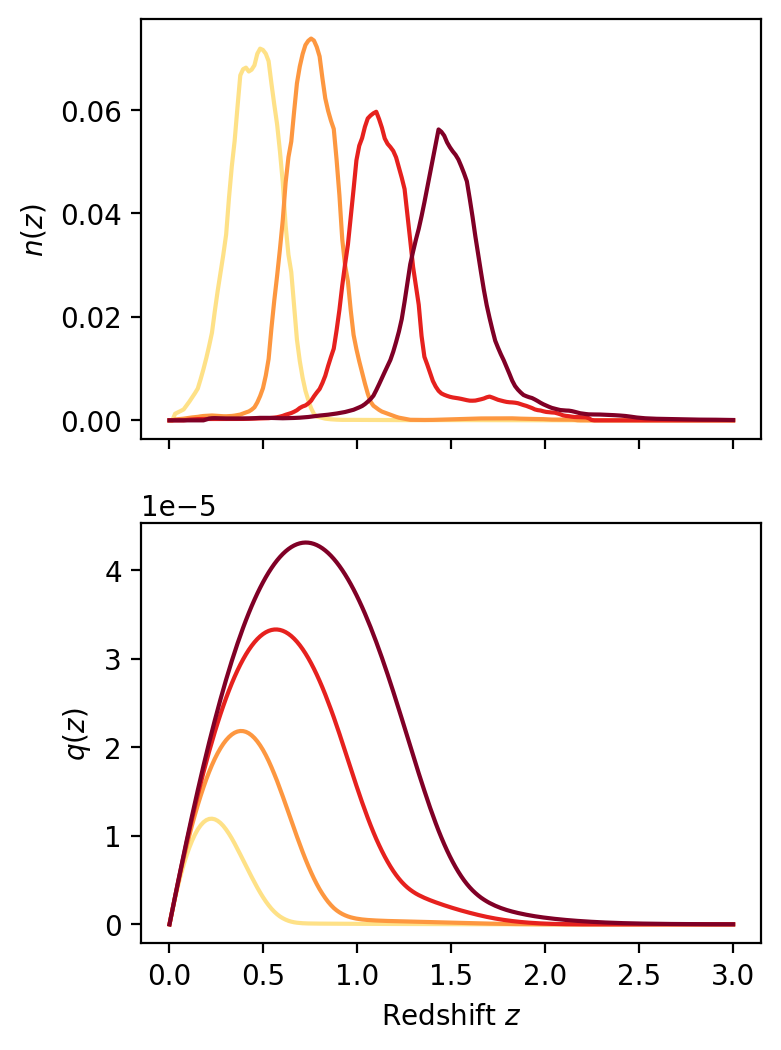

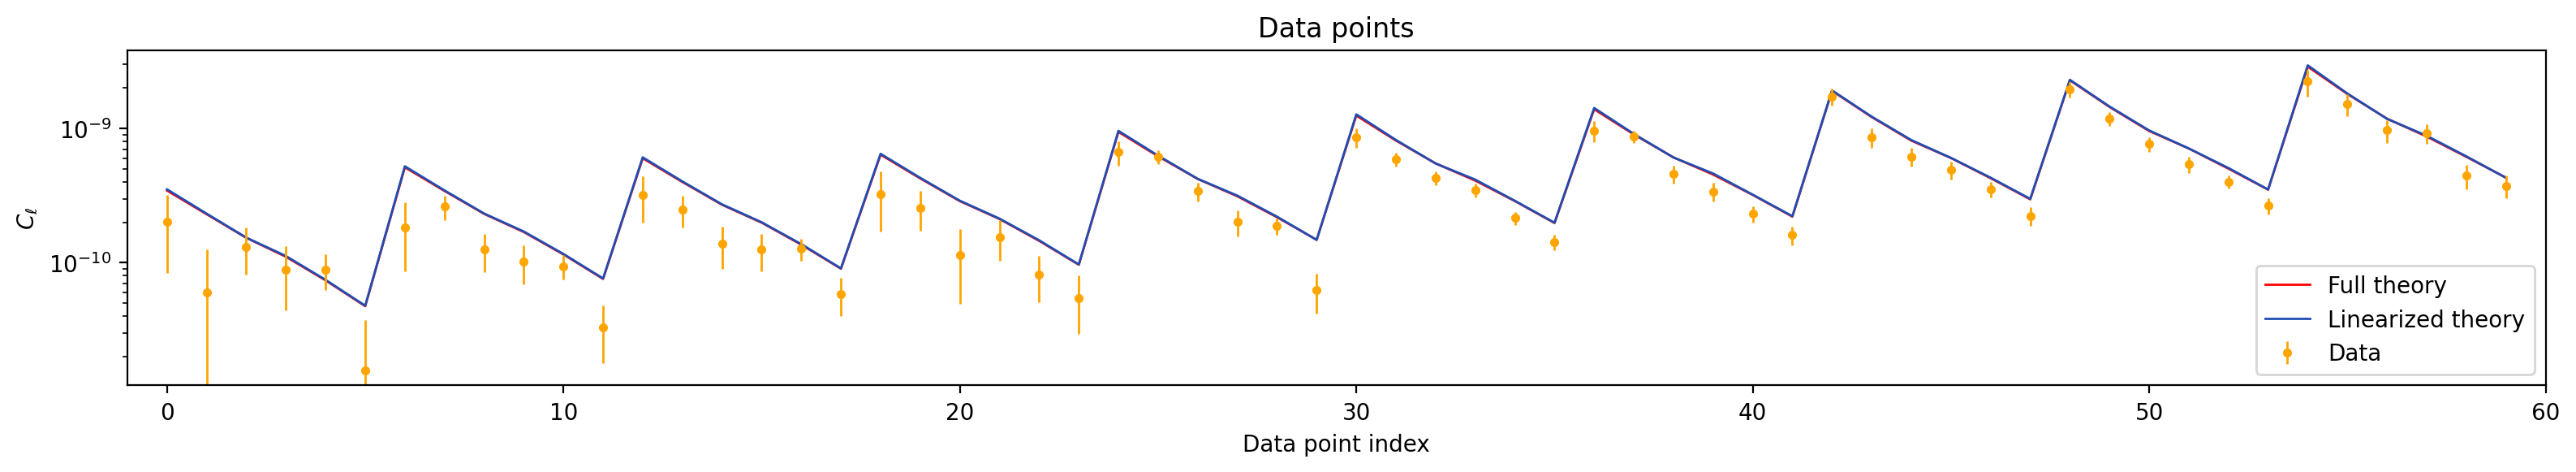

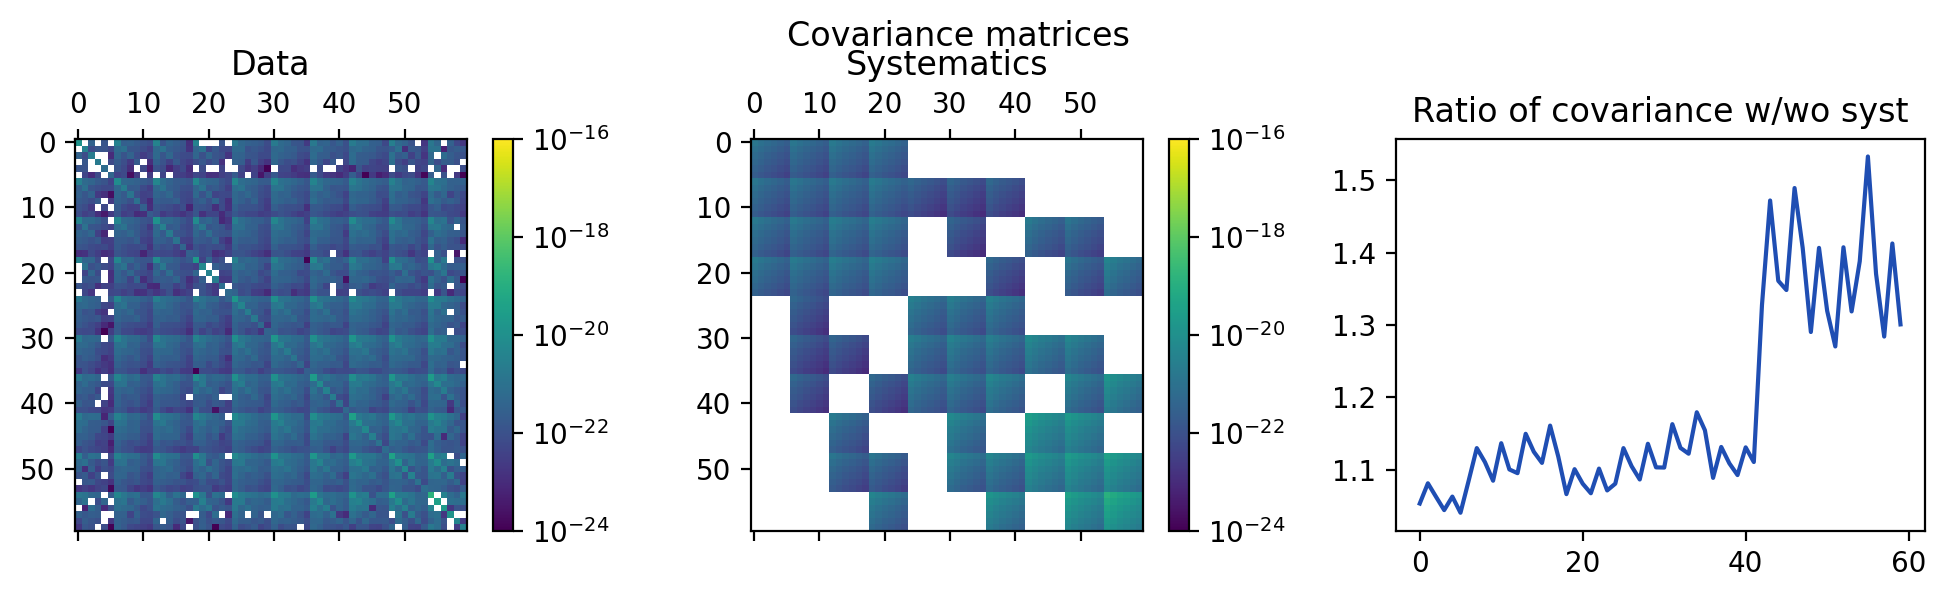

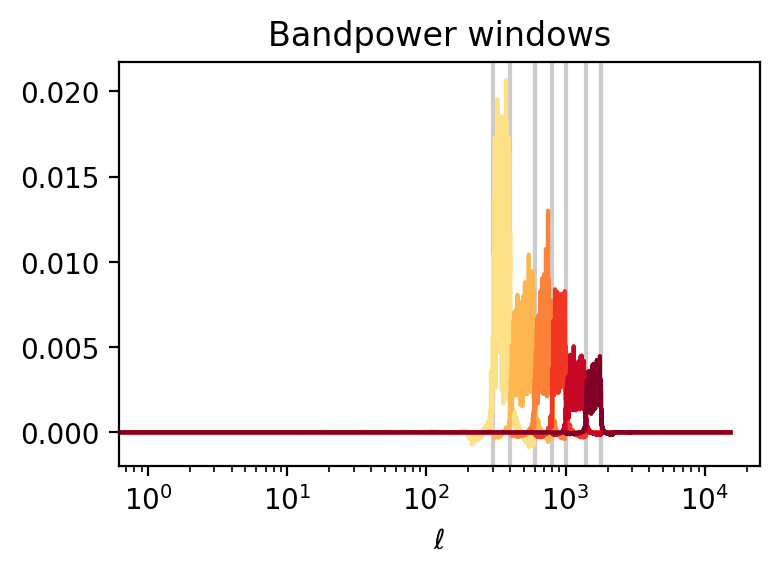

In [6]:
label = f'HSC_nk{nk}'

hsc_file = "data/hsc_y3_fourier_space_data_vector.sacc"
s = sacc.Sacc.load_fits(hsc_file)

# Redshift distribution
nz_z = s.tracers['wl_0'].z
nz_1 = s.tracers['wl_0'].nz
nz_2 = s.tracers['wl_1'].nz
nz_3 = s.tracers['wl_2'].nz
nz_4 = s.tracers['wl_3'].nz
nz_n = [nz_1, nz_2, nz_3, nz_4]

# Cl's and covariance
ell_edges = np.array([300, 400, 600, 800, 1000, 1400, 1800])
hsc_all_ells = s.get_ell_cl('cl_ee', 'wl_0', 'wl_0')[0]
hsc_covmat_elem = np.logical_and(ell_edges[0] < hsc_all_ells, hsc_all_ells < ell_edges[-1])
ell = hsc_all_ells[hsc_covmat_elem]
hsc_covmat_row = np.tile(hsc_covmat_elem, 10)
cov = s.covariance.covmat[hsc_covmat_row, :][:, hsc_covmat_row]
bpws = s.get_bandpower_windows(range(17)).weight[:, hsc_covmat_elem].T

bin_pairs = [(int(i[0][-1]), int(i[1][-1])) for i in s.get_tracer_combinations()]
cl_dict = {}
for b in bin_pairs:
    cl_dict[b] = s.get_ell_cl('cl_ee', 'wl_' + str(b[0]), 'wl_' + str(b[1]))[1][2:8]

# Priors
# For bins 1 and 2, these are the priors given in Table I of https://arxiv.org/pdf/2304.00701. For bin 3 and 4, the redshift parameters are actually posterior contraints, as the prior there is uniform, see Table VI.
mu_z = np.array([0., 0., -0.075, -0.157])
sigma_z = np.array([0.024, 0.022, 0.059, 0.111])
mu_shear = np.array([0., 0., 0., 0.])
sigma_shear = np.array([0.01, 0.01, 0.01, 0.01])

# Tracers
tracers = cls2pk.get_tracers(cosmo, nz_z, nz_n, delta_zs=mu_z)

# Prepare data
prepare_data(cosmo, label, ell, kk, tracers, bin_pairs, cl_dict, cov, mu_z, sigma_z, mu_shear, sigma_shear, ell_edges, bpws)

### KiDS-1000

/global/common/software/lsst/users/xuod/conda/plop2/lib/python3.9/site-packages/pyccl/tracers.py:150: CCLWarning: The number of samples in the n(z) (60) is smaller than the number of samples in the lensing kernel (256). Consider disabling spline integration for the lensing kernel by setting pyccl.gsl_params.LENSING_KERNEL_SPLINE_INTEGRATION = False before instantiating the Cosmology passed.
  warnings.warn(


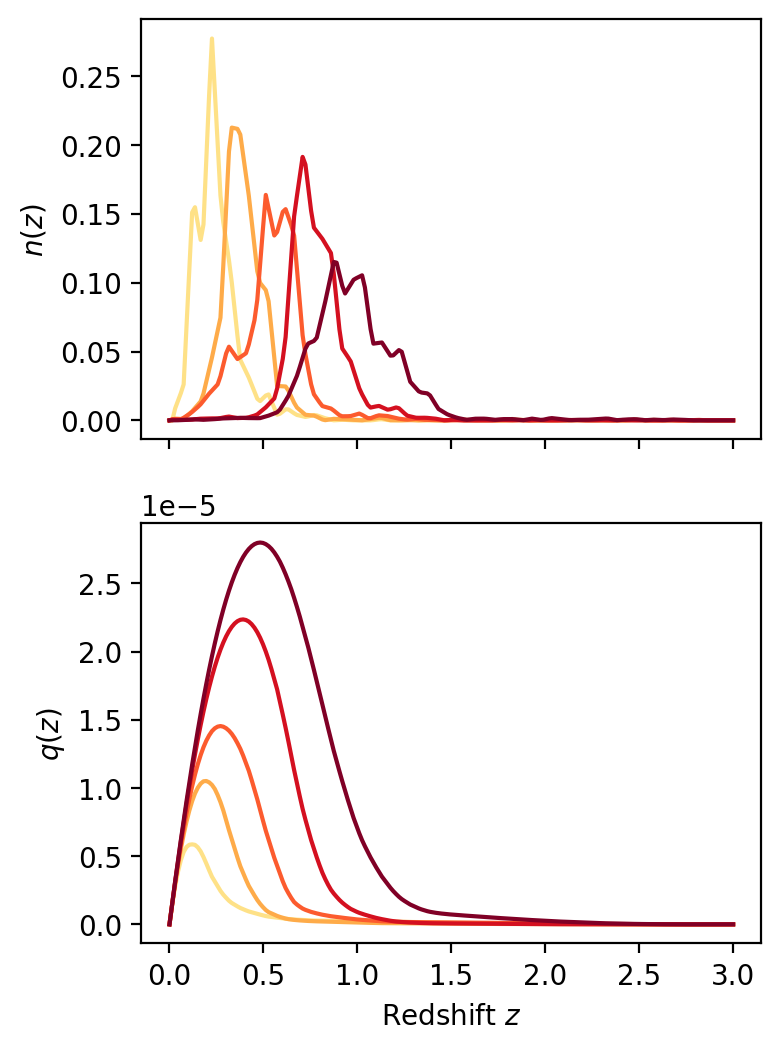

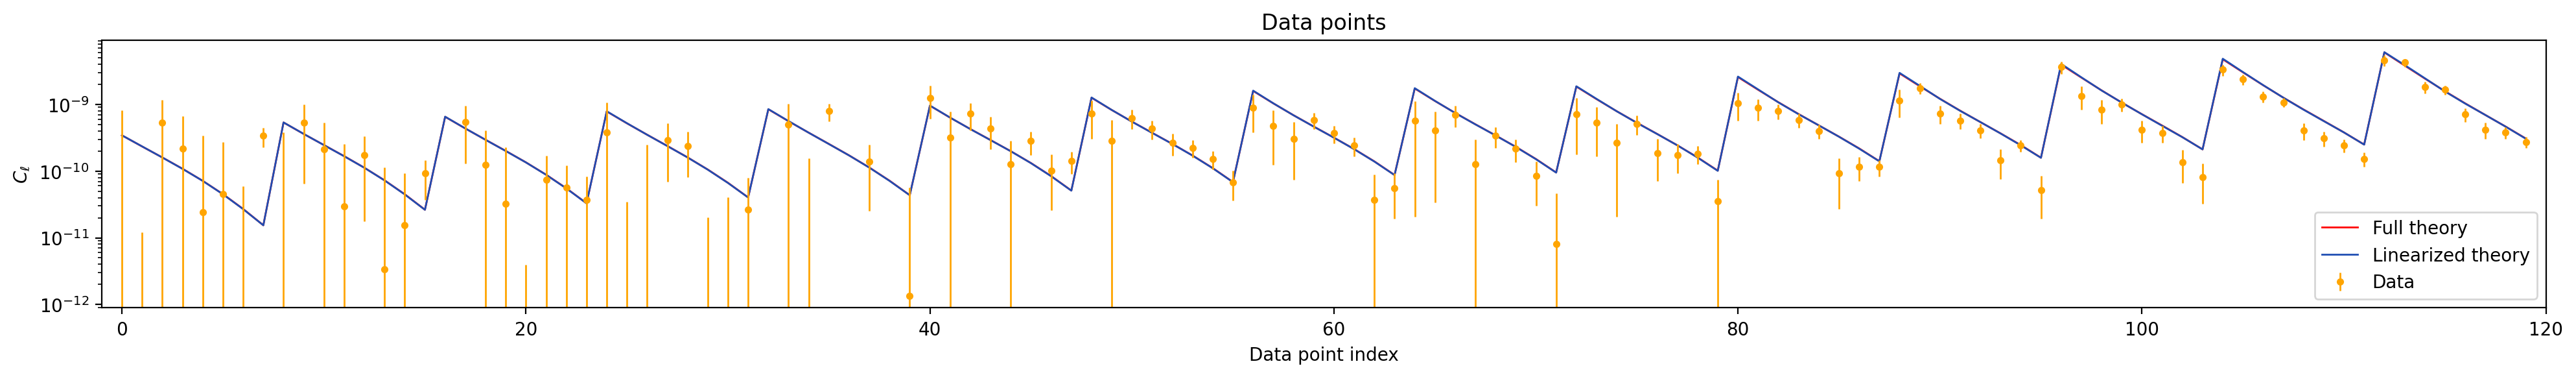

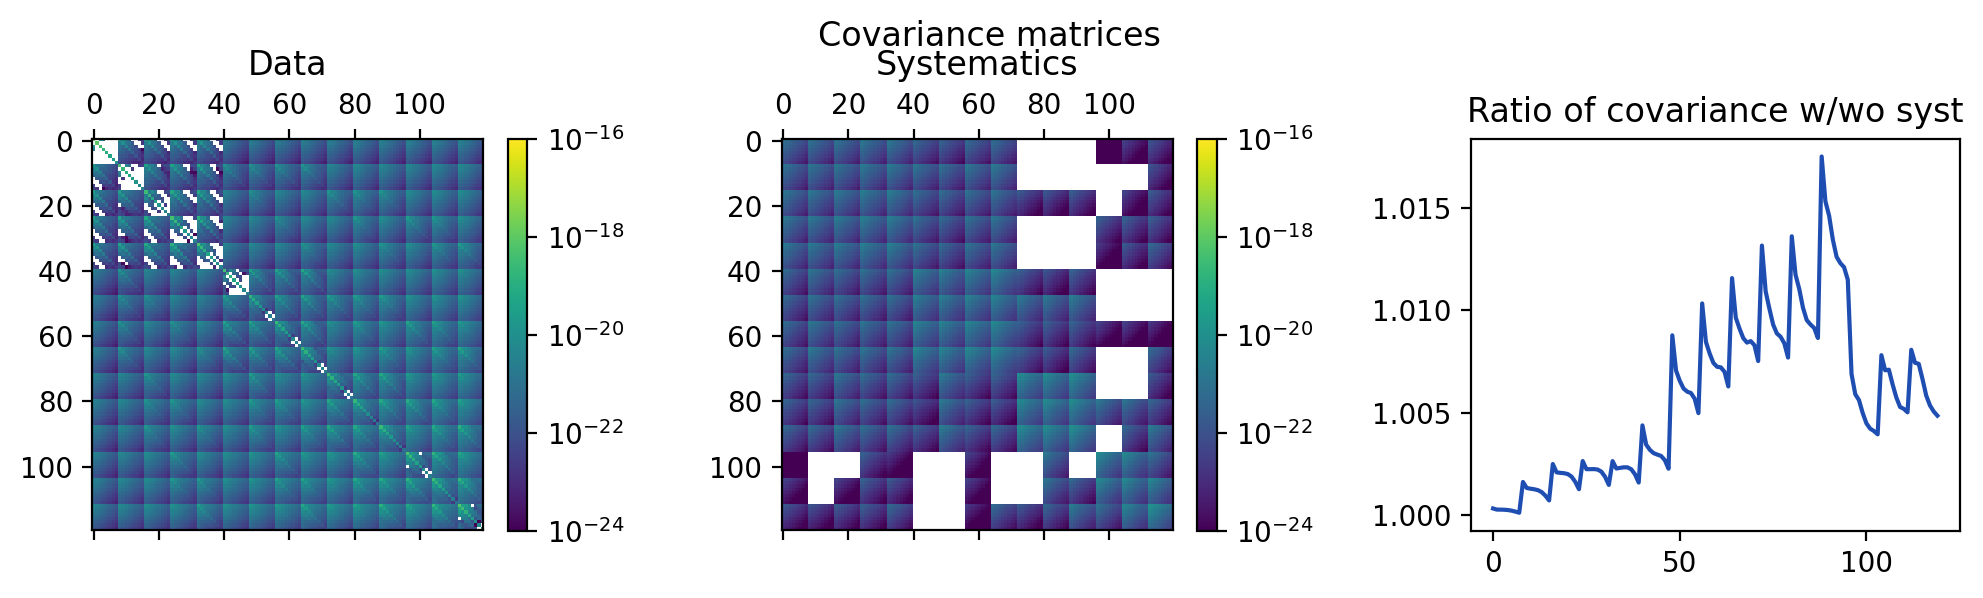

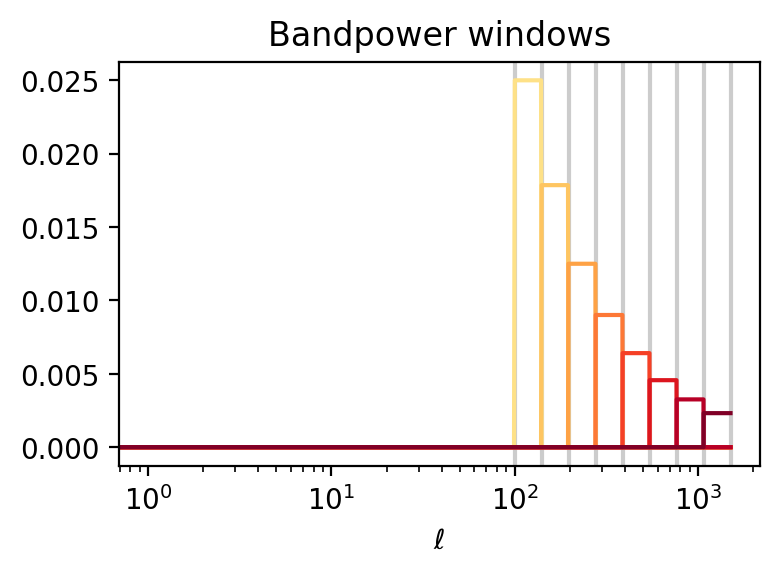

In [7]:
label = f'KiDS_nk{nk}'

kids_file = "data/bp_KIDS1000_BlindC_with_m_bias_V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_2Dbins_v2_goldclasses_Flag_SOM_Fid.fits"
F = fits.open(kids_file)

# Redshift distribution
ext = F["nz_source"]
nz_lim = 60
nz_z = ext.data.Z_MID[:nz_lim]
nz_1 = ext.data.BIN1[:nz_lim]
nz_2 = ext.data.BIN2[:nz_lim]
nz_3 = ext.data.BIN3[:nz_lim]
nz_4 = ext.data.BIN4[:nz_lim]
nz_5 = ext.data.BIN5[:nz_lim]
nz_n = [nz_1, nz_2, nz_3, nz_4, nz_5]

# Cl's and covariance
ext = F["COVMAT"]
cov_raw = ext.data[80:, 80:]

ext = F['PeeE']
ell = ext.data.ANG[0:8]
kids_cls_values = np.array_split(ext.data.VALUE, 15)
bin1 = ext.data.BIN1[::8]
bin2 = ext.data.BIN2[::8]
bin_pairs = [(bin1[i] - 1, bin2[i] - 1) for i in range(len(bin1))]
cl_dict = {}
for i in range(len(bin_pairs)):
    cl_dict[bin_pairs[i]] = kids_cls_values[i] / (ell * (ell + 1.))

ell_stack = np.tile(ell, len(cl_dict))
f = np.diag(1. / (ell_stack * (ell_stack + 1.)))
cov = f @ cov_raw @ f

ell_edges = np.geomspace(100, 1500, 9)
bpws = np.zeros((8, 1500))
for il in range(8):
    bpws[il, int(ell_edges[il]):int(ell_edges[il + 1])] = 1. / (int(ell_edges[il + 1] - int(ell_edges[il])))

# Priors
# These are posterior constraints shown in Table A.2 of https://arxiv.org/pdf/2007.15633
# mu_z = np.array([0.002, 0.011, -0.013, -0.016, 0.007])
# sigma_z = np.array([0.012, 0.014, 0.011, 0.009, 0.009])
mu_shear = np.array([0., 0., 0., 0., 0.])
sigma_shear = np.array([0., 0., 0., 0., 0.])
# Table 1 of https://arxiv.org/pdf/2007.15633
mu_z = np.array([0.000, 0.002, 0.013, 0.011, -0.006])
std_z = np.array([0.0106, 0.0113, 0.0118, 0.0087, 0.0097])
# Fig 6 of https://arxiv.org/pdf/2007.15635
corr = np.array([[1., 0.32, -0.17, 0.00, 0.04], [0.32, 1., 0.06, -0.11, -0.01], [0.17, 0.06, 1., -0.04, 0.02], [0.00, -0.11, -0.04, 1., 0.11],
                 [0.04, -0.01, 0.02, 0.11, 1.]])
sigma_z = np.diag(std_z) @ corr @ np.diag(std_z)

# Tracers
tracers = cls2pk.get_tracers(cosmo, nz_z, nz_n, delta_zs=mu_z)

# Prepare data
prepare_data(cosmo, label, ell, kk, tracers, bin_pairs, cl_dict, cov, mu_z, sigma_z, mu_shear, sigma_shear, ell_edges, bpws)

### ACT DR6

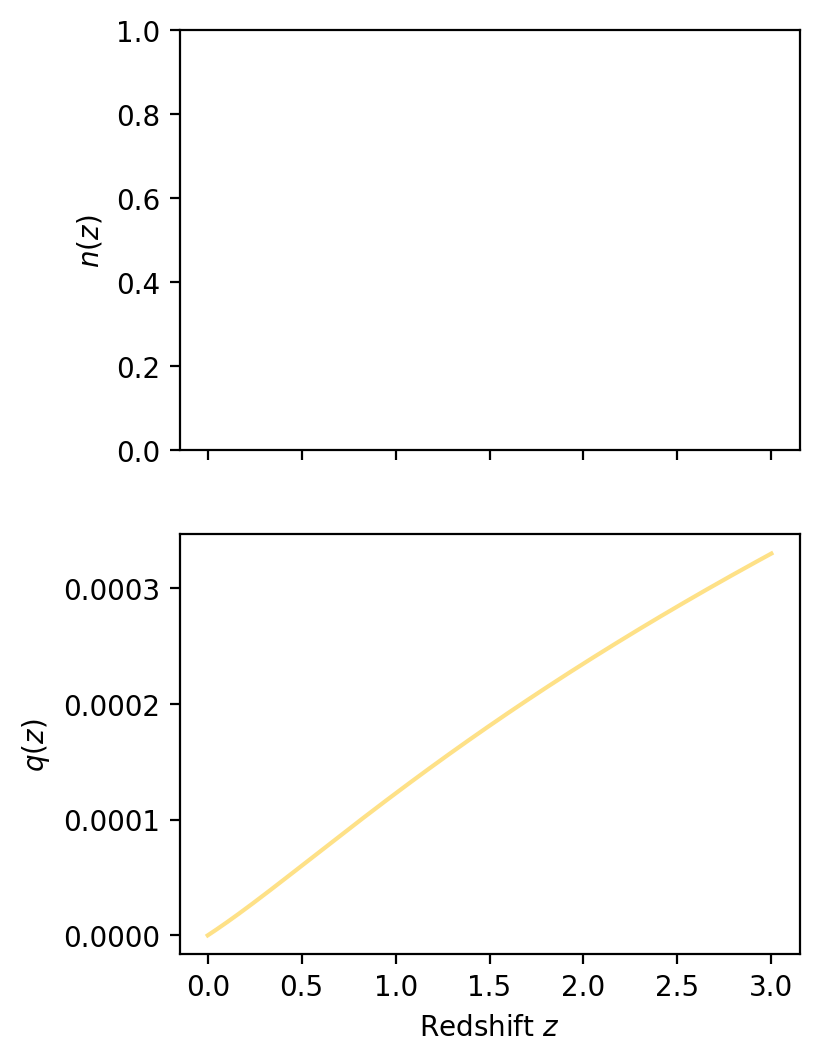

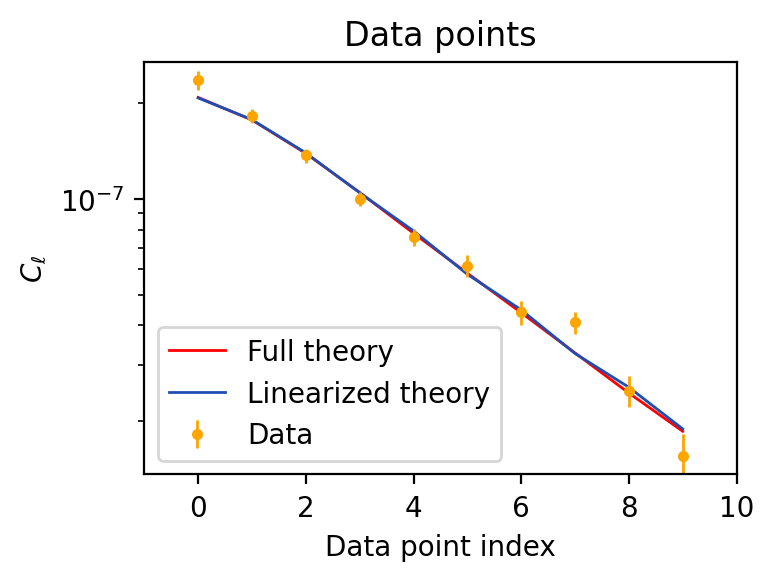

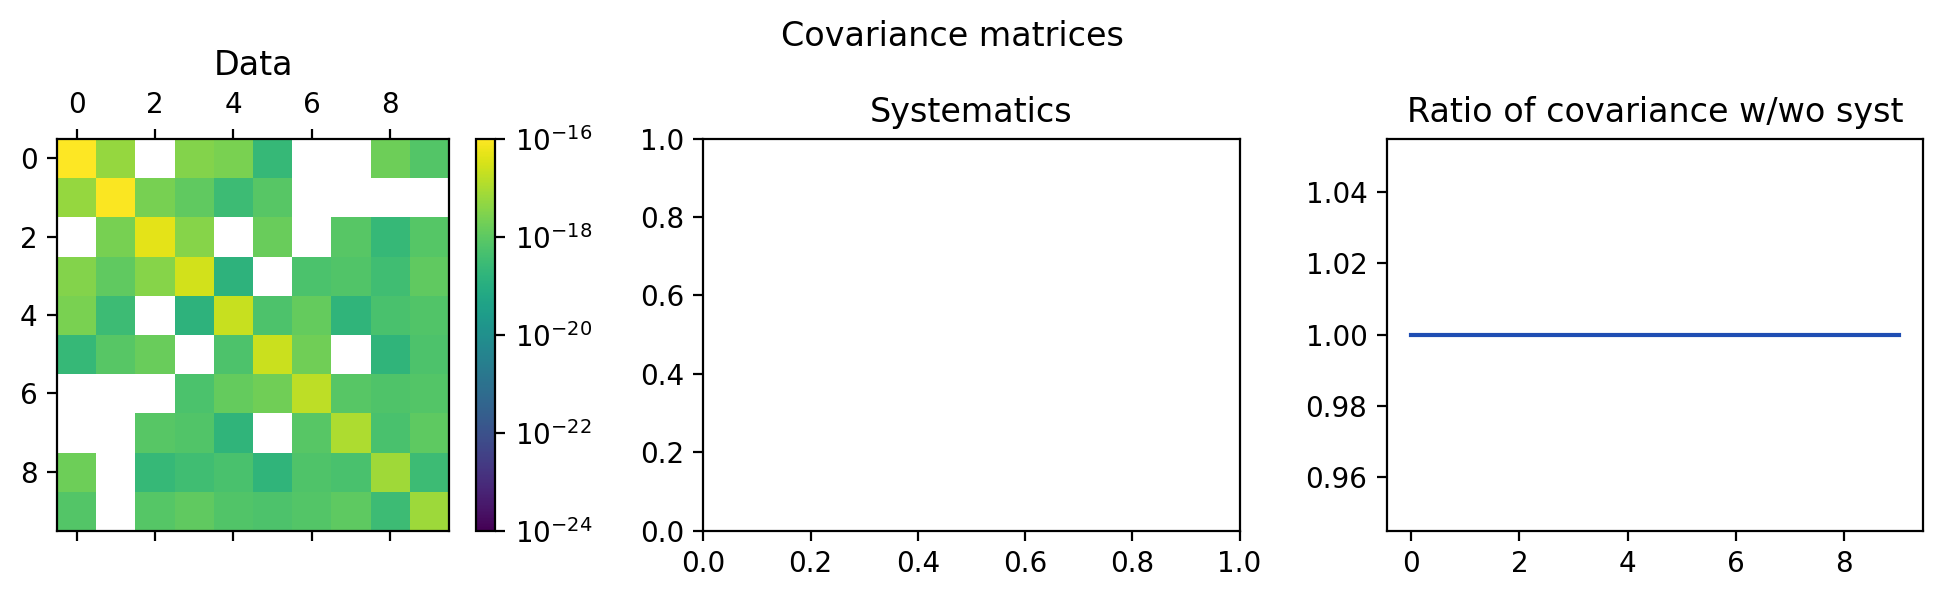

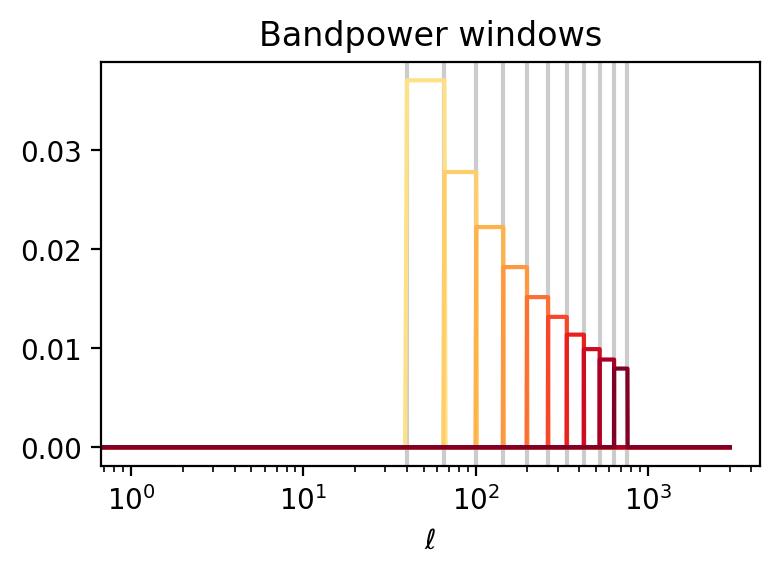

In [8]:
label = f'ACT_nk{nk}'

ell_edges = np.array([40, 66, 101, 145, 199, 264, 339, 426, 526, 638, 763])  # See 2304.05202, section 6.1 and the binning_matrix_act.txt file

bpws = np.loadtxt('data/binning_matrix_act.txt')
ell = bpws @ np.arange(bpws.shape[1])
w = (ell_edges[0] < ell) & (ell < ell_edges[-1])
ell = ell[w]
bpws = bpws[w]
cl_dict = {(0, 0): np.loadtxt('data/clkk_bandpowers_act.txt')[w]}
cov = np.loadtxt('data/covmat_act.txt')[w, :][:, w]

# Tracers
tracers = [pyccl.CMBLensingTracer(cosmo, z_source=1090.)]
bin_pairs = [(0, 0)]

# Prepare data
prepare_data(cosmo, label, ell, kk, tracers, bin_pairs, cl_dict, cov, ell_edges=ell_edges, bpws=bpws)

## $\alpha(k)$ inference
Using save $C_\ell$'s and window matrices, we implement a linear model $C_\ell\sim W(\ell, k) [1+\alpha(k)]$ and sample it using Hamiltonian Monte Carlo.

Note that we also include in this repository combined data sets with precomputed cross-covariance matrices. The full list is
```
labels = ['DES_nk24',
          'HSC_nk24',
          'KiDS_nk24',
          'ACT_nk24',
          'DES_nk24_HSC_nk24',
          'DES_nk24_KiDS_nk24',
          'DES_nk24_ACT_nk24',
          'HSC_nk24_KiDS_nk24',
          'HSC_nk24_ACT_nk24',
          'KiDS_nk24_ACT_nk24',
          'DES_nk24_HSC_nk24_KiDS_nk24',
          'DES_nk24_HSC_nk24_ACT_nk24',
          'DES_nk24_KiDS_nk24_ACT_nk24',
          'HSC_nk24_KiDS_nk24_ACT_nk24',
          'DES_nk24_HSC_nk24_KiDS_nk24_ACT_nk24']
```

In [9]:
# Pick a preprocessed data set
label = f'DES_nk{nk}'

data = np.load(os.path.join('./res/', f'{label}_cl_stack.npy'))
cov = np.load(os.path.join('./res/', f'{label}_cl_cov.npy'))
cov += np.load(os.path.join('./res/', f'{label}_cl_cov_syst.npy'))
window_matrix = np.load(os.path.join('./res/', f'{label}_window_matrix.npy'))

In [10]:
# Smoothing prior scale
sigma = 0.3 * np.log(kk[1] / kk[0])

with Model() as model:  # model specifications in PyMC are wrapped in a with-statement
    # Define priors
    alpha = Uniform("alpha", lower=-np.ones(nk), upper=np.ones(nk))

    # Smoothness prior
    if sigma is not None:
        prior = Normal(f"smooth", mu=alpha[1:] - alpha[:-1], sigma=sigma, observed=np.zeros(nk - 1))

    # Likelihood: the linear model is just this line!
    likelihood = MvNormal("Cls", mu=math.dot(window_matrix, 1. + alpha), cov=cov, observed=data)

    # Inference: draw posterior samples using NUTS sampling
    chain = sample(draws=1000, chains=8, cores=8)

alpha = np.vstack(chain.posterior.alpha)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [alpha]


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 17 seconds.


Now we plot the results, showing the mean and standard deviation of $\alpha(k)$'s for each $k$ bin.

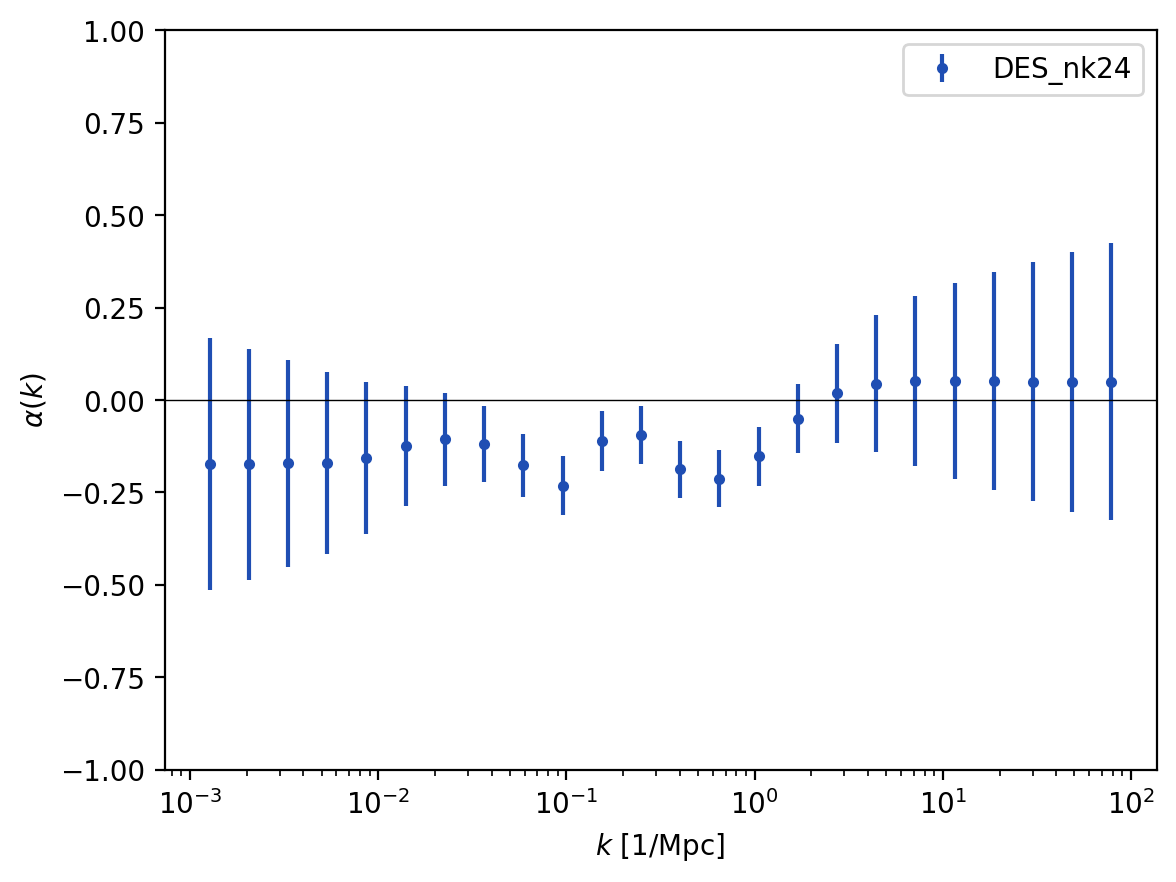

In [11]:
plt.errorbar(kk, np.mean(alpha, axis=0), np.std(alpha, axis=0), marker='.', ls=' ', color='#1f4eb3', label=label)
plt.axhline(0., c='k', lw=.5)
plt.xscale('log')
plt.xlabel('$k$ [1/Mpc]')
plt.ylim(-1, 1)
plt.ylabel(r'$\alpha(k)$')
plt.legend()

Depending on datasets and smoothing, the posterior may not be Gaussian, in which case it is better to show the 68% credible intervals, which is obtained from `getdist` utilities.

In [12]:
def get_lims(a):
    names = [f'a_{{{i}}}' for i in range(nk)]
    chain = MCSamples(samples=a, names=names, ranges={n: [-1, 1] for n in names})
    stats = chain.getMargeStats()
    return np.array([[stats.parWithName(n).limits[0].lower, stats.parWithName(n).limits[0].upper] for n in names]).T

Removed no burn in


Text(0, 0.5, '$\\alpha(k)$')

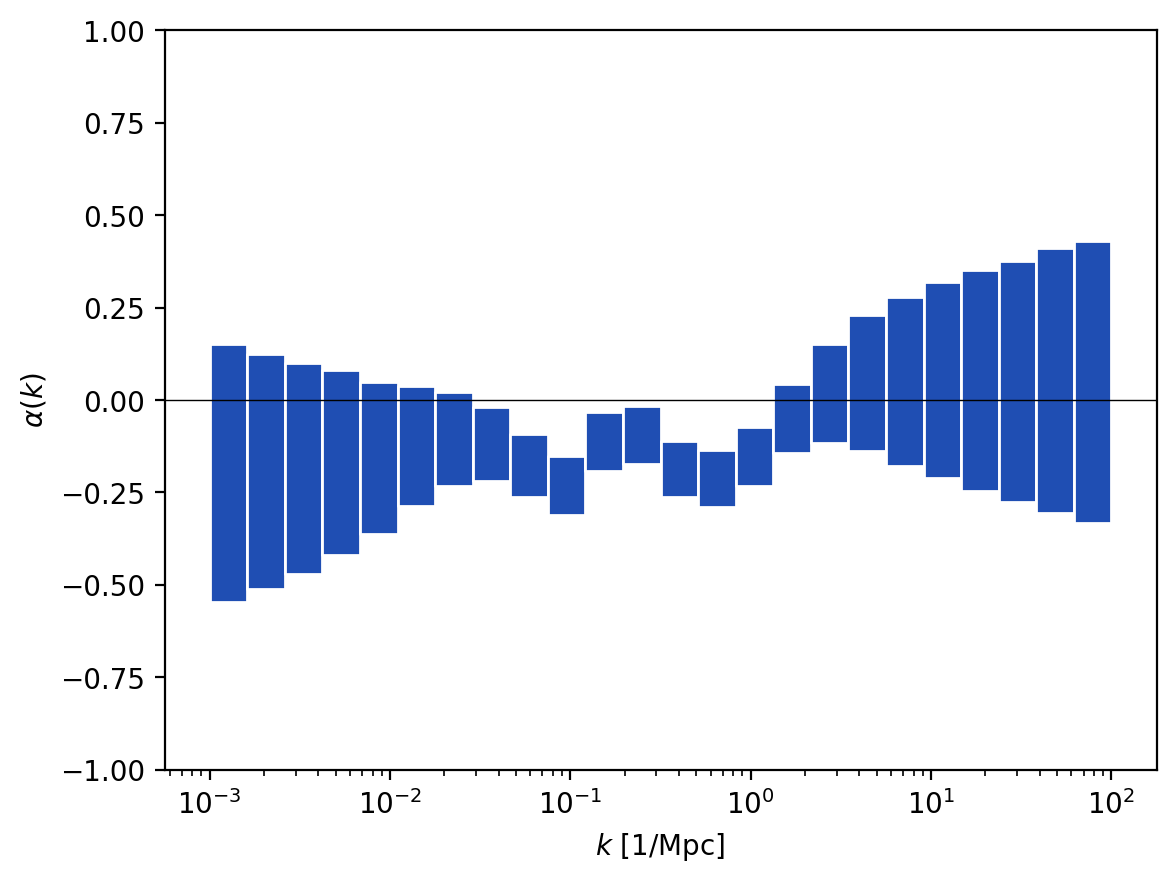

In [13]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

fig = plt.figure()
ax = fig.add_subplot(111)

lims = get_lims(alpha)
errorboxes = [Rectangle((k, l), ke, u - l) for k, ke, l, u in zip(kk_edges[:-1], np.diff(kk_edges), lims[0], lims[1])]
pc = PatchCollection(errorboxes, facecolor='#1f4eb3', edgecolor='w')
ax.add_collection(pc)

plt.axhline(0., c='k', lw=.5)
plt.xscale('log')
plt.xlabel('$k$ [1/Mpc]')
plt.ylim(-1, 1)
plt.ylabel(r'$\alpha(k)$')

As explained in the paper, the smoothing prior decorrelates adjacent bins, which can be seen in the correlation matrix.

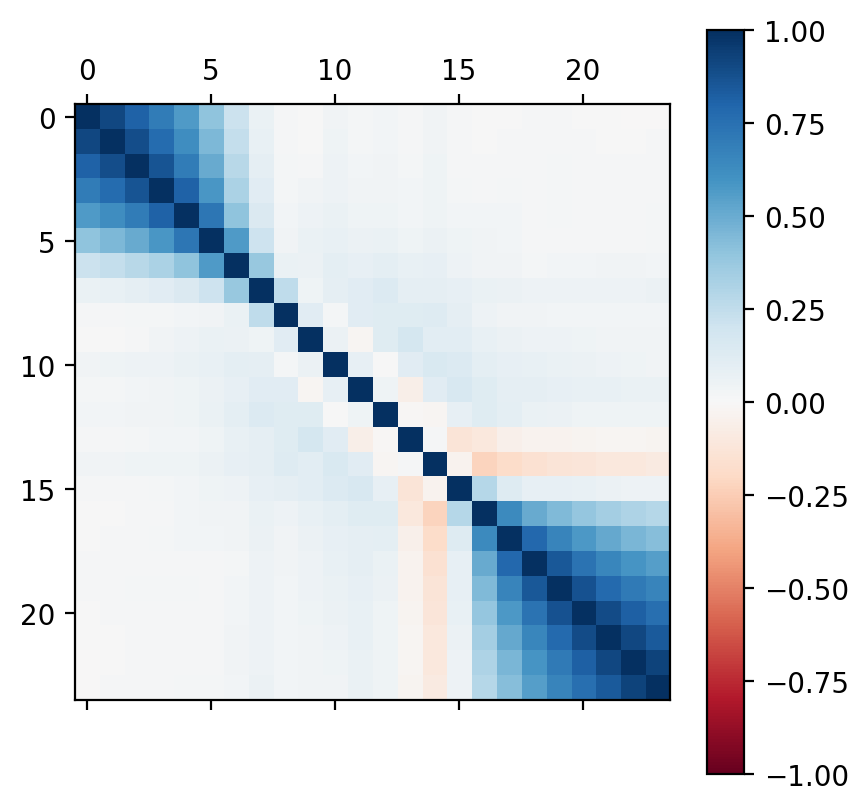

In [14]:
corr = np.corrcoef(alpha, rowvar=False)
plt.matshow(corr, cmap=mpl.cm.RdBu, norm=mpl.colors.Normalize(-1, 1))
plt.colorbar()

# Explore ΛCDM extensions
We illustrate how the $\alpha(k)$ posteriors can be used as a derived likelihood to fit models of the power spectrum ddeviating from Planck ΛCDM. We caution the user to be careful when doing so and refer to the paper for the main restrictions, in particular:
- The same background cosmology must be used to compute window matrices and here.
- Make sure the model is a good fit, which may require varying $\sigma_8$ along with the power spectrum parameters.

Here we demonstrate how the simple $A_{\rm mod}$ model can be constrained.

First, we define the model.

In [15]:
def alpha_th(param_dict, k, a, pknl_0):
    params = dict(
        sigma8=float(param_dict.get('sigma8', None)),
        Omega_c=planck_params['omega_c'] / (planck_params['H0'] / 100.)**2,
        Omega_b=planck_params['omega_b'] / (planck_params['H0'] / 100.)**2,
        h=planck_params['H0'] / 100.,
        n_s=planck_params['n_s'],
        m_nu=[0.06, 0., 0.],
        Neff=3.046)

    cosmo = pyccl.Cosmology(**params)
    pknl = pyccl.nonlin_matter_power(cosmo, k, a)
    pklin = pyccl.linear_matter_power(cosmo, k, a)
    pkmod = pklin + float(param_dict.get('Amod', 1.)) * (pknl - pklin)

    return pkmod / pknl_0 - 1.


def alpha_likelihood(param_dict, k, a, pknl_0, dist):
    return dist.logpdf(alpha_th(param_dict, k, a, pknl_0))

Second, we construct a likelihood from the $\alpha(k)$ posterior.

In [16]:
label = f'DES_nk{nk}'
zeff = 0.36  # Effective redshift (see paper)
kmin, kmax = 0.0287, 1.334  # Constrained k-range (see paper)

w = (kmin < kk) & (kk < kmax)
dist = scipy.stats.multivariate_normal(mean=np.mean(alpha, axis=0)[w], cov=np.cov(alpha, rowvar=False)[w, :][:, w])
likelihood_kwargs = dict(k=kk[w], a=1 / (1 + zeff), pknl_0=pyccl.nonlin_matter_power(cosmo, kk[w], 1 / (1 + zeff)), dist=dist)

Third, we run inference using `nautilus`.

In [17]:
prior = Prior()
prior.add_parameter('Amod', dist=(0.5, 1.5))
prior.add_parameter('sigma8', dist=(0.6, 1.))

sampler = Sampler(prior, alpha_likelihood, likelihood_kwargs=likelihood_kwargs, pass_dict=True, pool=32, n_live=64, filepath=f'ext/Amod_{label}.hdf5', resume=True)

sampler.run(n_eff=200, verbose=True)

Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 8      | 1        | 4        | 1024     | N/A    | 419   | +7.73    


True

Finally, we visualize constraints with `getdist`.

Removed no burn in


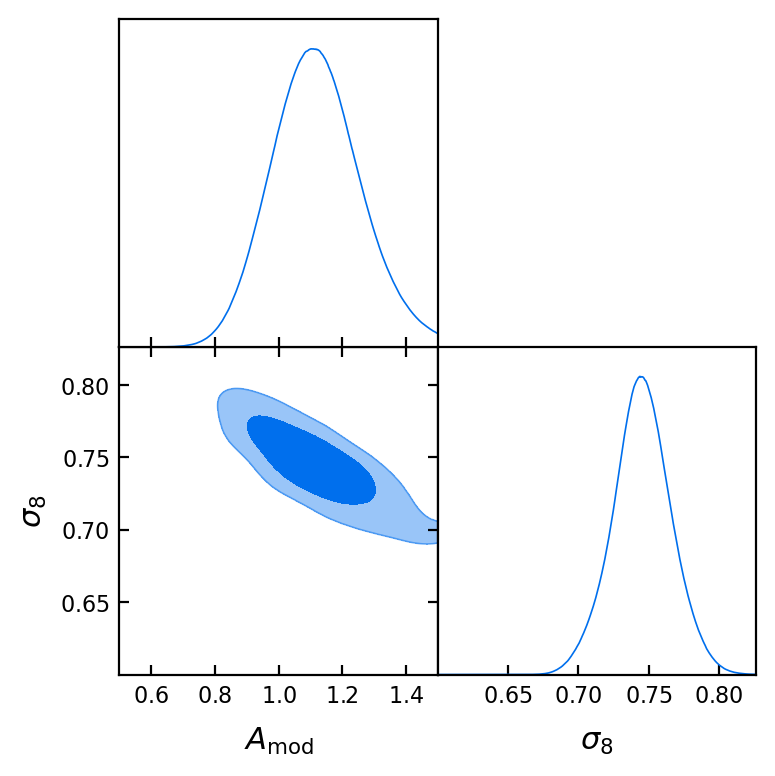

In [18]:
points, log_w, log_l = sampler.posterior()

sample = MCSamples(
    samples=points,
    weights=np.exp(log_w),
    loglikes=-log_l,
    names=['Amod', 'sigma8'],
    labels=[r'A_{\rm mod}', r'\sigma_8'],
    ranges={
        'Amod': (0.5, 1.5),
        'sigma8': (0.6, 1.)
    },
    label=label)

g = plots.get_subplot_plotter()
g.triangle_plot([sample], param1='Amod', param2='sigma8', filled=True)

Don't forget to make sure it's a good fit!

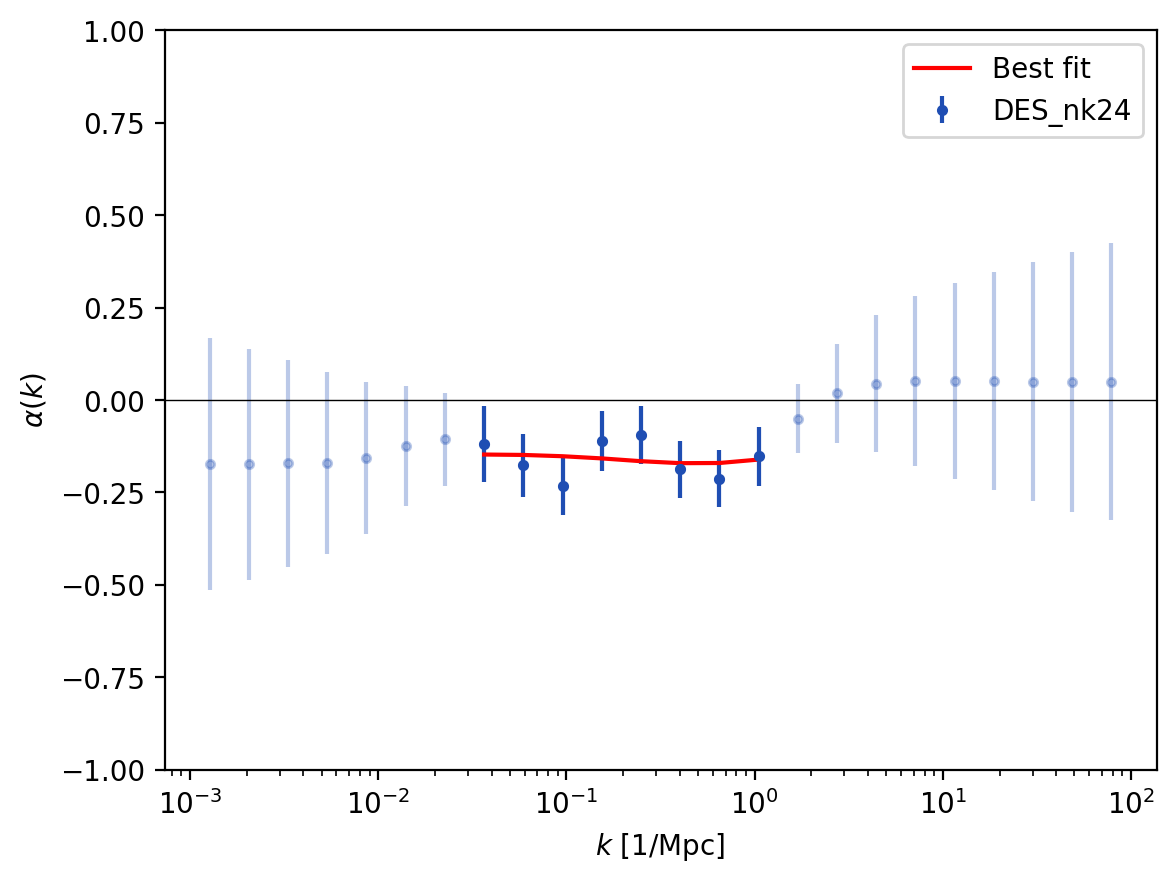

In [19]:
idx = np.argmax(log_l)
alpha_th_bestfit = alpha_th({'Amod': points[idx, 0], 'sigma8': points[idx, 1]}, likelihood_kwargs['k'], likelihood_kwargs['a'], likelihood_kwargs['pknl_0'])

plt.errorbar(kk, np.mean(alpha, axis=0), np.std(alpha, axis=0), marker='.', ls=' ', color='#1f4eb3', alpha=.3)
plt.errorbar(kk[w], np.mean(alpha[:, w], axis=0), np.std(alpha[:, w], axis=0), marker='.', ls=' ', color='#1f4eb3', label=label)
plt.plot(kk[w], alpha_th_bestfit, c='r', label='Best fit')
plt.axhline(0., c='k', lw=.5)
plt.xscale('log')
plt.xlabel('$k$ [1/Mpc]')
plt.ylim(-1, 1)
plt.ylabel(r'$\alpha(k)$')
plt.legend()